In [3]:
import time
import scipy.io as sio
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.utils import shuffle
import time
from sklearn.preprocessing import scale

%matplotlib inline

In [4]:
file_test ='test.csv'
file_train ='train.csv'

In [6]:
# create the training & test sets, skipping the header row with [1:]
dataset = pd.read_csv(file_train)
target = dataset[[0]].values.ravel()
train = dataset.iloc[:,1:].values
test = pd.read_csv(file_test).values

In [32]:
X_test = test.copy()
X = train.copy()
y = target.copy()

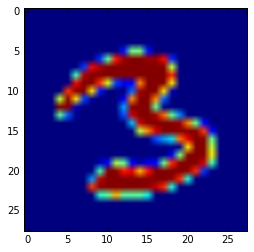

In [35]:
plt.imshow(X_test[901].reshape(28,-1))
plt.show()


In [36]:
X = scale(X, axis=1)
X_test = scale(X_test, axis=1)
X,y = shuffle(X,y, random_state = 0)

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [37]:
# split into training/validation set. add column of 1 for intercept
X_train = X[:5*len(y)/6]
y_train = y[:5*len(y)/6]
X_val = X[5*len(y)/6:]
y_val = y[5*len(y)/6:]
X_train = np.hstack((X_train,np.ones(len(X_train)).reshape(-1,1)))
X_val = np.hstack((X_val,np.ones(len(X_val)).reshape(-1,1)))
X_test = np.hstack((X_test,np.ones(len(X_test)).reshape(-1,1)))

In [38]:
print X_train.shape
print X_val.shape
print X_test.shape
print y_train.shape
print X.shape

(35000L, 785L)
(7000L, 785L)
(28000L, 785L)
(35000L,)
(42000L, 784L)


In [39]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [40]:
y = np.array([[1,2,3],[1,2,3]])
z = np.array([1,1,3])

In [41]:
z.reshape(-1,1)

array([[1],
       [1],
       [3]])

In [42]:
def compute_numerical_gradient(N,X,y):
    param_initial = N.get_params()
    numgrad = np.zeros(param_initial.shape)
    perturb = np.zeros(param_initial.shape)
    print numgrad.shape
    e = 1e-4

    print "param_initial ", param_initial, len(param_initial)   
    
    for p in xrange(len(perturb)-2, len(perturb)):
        # set perturbation vector
        print p
        perturb[p] = e
        N.set_params(param_initial + perturb)
       
        a2= N.forward(X)
        b2 = N.one_hot(y)
        #print type(a), a.shape
        #print "MSE", MSE(a2[0], b2.iloc[0]) , "shape a2[0]", a2[0].shape, "shape b2.iloc[0]", b2.iloc[0].shape
        
        loss2 = np.sum([MSE(a2[i], b2.iloc[i]) for i in xrange(a2.shape[0])])
        print "loss2", loss2

        N.set_params(param_initial - perturb)

        a1= N.forward(X)

        b1 = N.one_hot(y)
        loss1 = np.sum([MSE(a1[i], b1.iloc[i]) for i in xrange(a1.shape[0])])
        print "loss1", loss1

        #print " a2 != a1?", np.sum(a2 != a1)
        # compute numerical gradient
        numgrad[p] = (loss2-loss1)/(2*e)
        
        # return the value we changed back to zero
        perturb[p] = 0
    
    # return params to original value
    N.set_params(param_initial)
        
    return numgrad

In [43]:
def one_hot(y):
    '''
    Input: vector
    Returns: one-hot encoding
    '''
    return pd.get_dummies(y.ravel())

In [44]:
y_hot = one_hot(y_train)

In [46]:
class Neural_Network(object):
    def __init__(self, learning_rate, epochs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.n_in = 784
        #self.n_in = images.shape[1]
        self.n_hid = 200
        self.n_out = 10
        #self.n_out = len(np.unique(labels))
        self.V = 0.1*np.random.rand(self.n_hid,self.n_in+1)
        self.W = 0.1*np.random.rand(self.n_out,self.n_hid + 1)
        
    def sigmoid(self, z):
        # apply sigmoid activation function
        return 1/(1+np.exp(-z))
    
    def sigmoid_prime(self,z):
        # derivative of sigmoid function
        g = self.sigmoid(z)
        return np.multiply(g, 1-g)
    
    def tanh_prime(self,z):
        # derivative fo tanh function
        return 1 - np.tanh(z)**2
    
    def MSE(self,y):
        '''
        Mean-squared error function
        y: vector, length n_out, ground truth label
        z: vector, length n_out, z_k = value of k-th unit of output layer
        '''
        return .5*np.sum(np.square(np.linalg.norm(y - self.y_hat)))

    def CEE(self,y):
        '''
        Cross-entropy error function
        y: vector, length n_out, ground truth label
        z: vector, length n_out, z_k = value of k-th unit of output layer
        '''
        #return sum(-(np.multiply(y,np.log(self.y_hat)) + np.multiply(1.0-y, np.log(1.0-self.y_hat))))
        return -sum(y*np.log(self.y_hat) + (1-y)*np.log(1-self.y_hat))
    
    #def forward(self, X):
    #    #propagate inputs through network
    #    self.VX = np.dot(X,self.V.T)
    #    self.h = np.tanh(self.VX)
    #    
    #    print "h",self.h.shape
    #    print "np.ones(self.h.shape[0]).reshape(-1,1)", np.ones(self.h.shape[0]).reshape(-1,1).shape
    #    self.h1 = np.vstack((self.h,np.ones(self.h.shape[1]).reshape(-1,1)))
    #    
    #    print "h1",self.h1.shape
    #    
    #    self.Wh = np.dot(self.h1,self.W.T)
    #    self.y_hat = self.sigmoid(self.Wh)
    #    
    #    return self.y_hat
    
    def forward(self, X):
        '''weights: trained weights, i.e. V;W
        images: test set (features)
        1. Compute labels of all images using the weights, V;W
        2. return labels '''
        
        V = self.V
        W = self.W

        self.VX = np.dot(V, X.T)
        self.h = np.tanh(self.VX)
        if self.h.ndim>1:
            self.h1 = np.vstack((self.h, np.ones(self.h.shape[1])))
        else:
            self.h1 = np.append(self.h, 1)
        self.Wh = np.dot(W, self.h1)
        self.y_hat = self.sigmoid(self.Wh).T 
        return self.y_hat
    
    
    def MSE_prime(self, X, y):
        '''
        Cost function : Mean Squared Error
        compute derivative with respect to V and W
        
        Input:
        -----------------------------------------
        X: vector size 784
        y: vector size 10 (one hot encoded)
        
        Return: dJ/dV, dJ/dW
        '''
        
        self.y_hat = self.forward(X)
        delta3 = np.multiply((-(y-self.y_hat)), self.sigmoid_prime(self.Wh))
        
        dJdW = np.dot(self.h1.reshape(self.h1.shape[0],1),  delta3.reshape(delta3.shape[0],1).T).T       # shape dJdW (10L,201L)
        delta1 = np.dot(delta3, self.W)
        delta1 = np.delete(delta1, 200) # delete last column
        
        tmp = self.tanh_prime(self.VX)
        delta2 = np.multiply(delta1,tmp)
        dJdV = np.dot(X.reshape(X.shape[0],1), delta2.reshape(delta2.shape[0],1).T).T
        return dJdV, dJdW
    
    def CEE_prime(self, X, y):
        '''
        Cost function : Cross-entropy error
        compute derivative with respect to V and W
        
        Input:
        -----------------------------------------
        X: vector size 784
        y: vector size 10 (one hot encoded)
        
        Return: dJ/dV, dJ/dW
        '''
        
        self.y_hat = self.forward(X)
        delta3 = -(y-self.y_hat)
        
        dJdW = np.dot(self.h1.reshape(self.h1.shape[0],1),  delta3.reshape(delta3.shape[0],1).T).T       # shape dJdW (10L,201L)
        delta1 = np.dot(delta3, self.W)
        delta1 = np.delete(delta1, 200) # delete last column
        
        tmp = self.tanh_prime(self.VX)
        delta2 = np.multiply(delta1,tmp)
        dJdV = np.dot(X.reshape(X.shape[0],1), delta2.reshape(delta2.shape[0],1).T).T
        return dJdV, dJdW
        
    def train(self,images, labels, cost_function):
        '''
        Train dat neural net
        
        Input:
        --------------------------------------------
        images: array-like n_samples x n_in , training instances
        labels: vector size n_samples, target labels
        cost_function: 'MSE' (mean squared error) or 'CEE' (cross entropy)   
        
        Returns:
        --------------------------------------------
        self
        '''        
        start = time.time()
        # store costs
        self.cost = []
        
        self.pred_train = []
        self.pred_val =[]
        count = 0
        
        if cost_function == "MSE":
            for e in xrange(self.epochs):
                if e>=1:
                    tmp = time.time()
                    print "epoch",e, "latest validation accuracy", self.pred_val[-1], "Time elapsed", tmp-start
                X,y = shuffle(images,labels)

                for i in xrange(X.shape[0]):
                    self.train_MSE(X[i],y.iloc[i])
                    count += 1

                    if count%1000 == 0:
                        self.forward(images)                
                        J = self.MSE(labels)
                        self.cost.append(J)

                        pred_train = self.predict(X_train)
                        predictions_train = []
                        for i in xrange(pred_train.shape[0]):
                            predictions_train.append(np.argmax(pred_train[i]))
                        acc_train = np.sum(predictions_train == y_train.ravel())/float(len(y_train.ravel()))
                        #print "accuracy train", acc_train
                        self.pred_train.append(acc_train)

                        pred_val = self.predict(X_val)
                        predictions_val = []
                        for i in xrange(pred_val.shape[0]):
                            predictions_val.append(np.argmax(pred_val[i]))
                        acc_val = np.sum(predictions_val == y_val.ravel())/float(len(y_val.ravel()))
                        #print "accuracy val", acc_val
                        self.pred_val.append(acc_val)
        elif cost_function == "CEE":
            for e in xrange(self.epochs):
                if e>=1:
                    tmp = time.time()
                    print "epoch",e, "latest validation accuracy", self.pred_val[-1], "Time elapsed", tmp-start
                X,y = shuffle(images,labels)

                for i in xrange(X.shape[0]):
                    self.train_CEE(X[i],y.iloc[i])
                    count += 1

                    if count%1000 == 0:
                        self.forward(images)                
                        J = self.CEE(labels)
                        self.cost.append(J)

                        pred_train = self.predict(X_train)
                        predictions_train = []
                        for i in xrange(pred_train.shape[0]):
                            predictions_train.append(np.argmax(pred_train[i]))
                        acc_train = np.sum(predictions_train == y_train.ravel())/float(len(y_train.ravel()))
                        #print "accuracy train", acc_train
                        self.pred_train.append(acc_train)

                        pred_val = self.predict(X_val)
                        predictions_val = []
                        for i in xrange(pred_val.shape[0]):
                            predictions_val.append(np.argmax(pred_val[i]))
                        acc_val = np.sum(predictions_val == y_val.ravel())/float(len(y_val.ravel()))
                        #print "accuracy val", acc_val
                        self.pred_val.append(acc_val)
        else:
            print "Cost function not available"
    
    
    def train_MSE(self,images, labels):
        djdv, djdw = self.MSE_prime(images,labels)
        self.W -= self.learning_rate*djdw
        self.V -= self.learning_rate*djdv
    
    def train_CEE(self,images, labels):
        djdv, djdw = self.CEE_prime(images,labels)
        self.W -= self.learning_rate*djdw
        self.V -= self.learning_rate*djdv
    
    
    def predict(self, images):
        self.forward(images)
        return self.y_hat
        
    def get_params(self):
        # get V and W rolled into vector
        params = np.concatenate((self.V.ravel(), self.W.ravel()))
        return params
    
    def set_params(self, params):
        # set V and W using single parameter vector
        V_start = 0
        V_end = self.n_hid*self.n_in
        self.V = np.reshape(params[V_start:V_end], \
                           (self.n_hid, self.n_in))
        W_end = V_end+ self.n_hid*self.n_out
        self.W = np.reshape(params[V_end:],\
                           (self.n_out,self.n_hid))
        
    def compute_gradients(self,X,y):
        dJdV, dJdW = self.cost_function_prime(X,y)
        return np.concatenate((dJdV.ravel(), dJdW.ravel()))
    
    

In [47]:
start = time.time()
NN_CEE = Neural_Network(0.01,30)
NN_CEE.train(X_train,y_hot,"CEE")
end = time.time()
print "Total duration",end-start

epoch 1 latest validation accuracy 0.953857142857 Time elapsed 136.585000038
epoch 2 latest validation accuracy 0.961428571429 Time elapsed 277.681999922
epoch 3 latest validation accuracy 0.964571428571 Time elapsed 427.858999968
epoch 4 latest validation accuracy 0.966 Time elapsed 577.319000006
epoch 5 latest validation accuracy 0.966857142857 Time elapsed 725.131999969
epoch 6 latest validation accuracy 0.968142857143 Time elapsed 873.023000002
epoch 7 latest validation accuracy 0.970428571429 Time elapsed 1020.87899995
epoch 8 latest validation accuracy 0.970857142857 Time elapsed 1167.82800007
epoch 9 latest validation accuracy 0.972428571429 Time elapsed 1305.27800012
epoch 10 latest validation accuracy 0.974142857143 Time elapsed 1442.52600002
epoch 11 latest validation accuracy 0.972142857143 Time elapsed 1578.83200002
epoch 12 latest validation accuracy 0.973142857143 Time elapsed 1722.57299995
epoch 13 latest validation accuracy 0.974 Time elapsed 1868.00600004
epoch 14 late

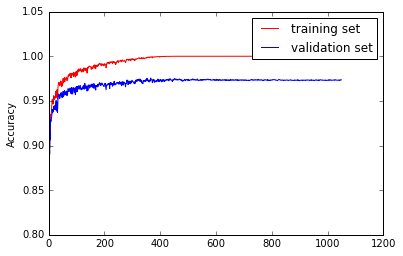

In [48]:
plt.plot(NN_CEE.pred_train, color = 'red')
plt.plot(NN_CEE.pred_val, color = 'blue')
plt.ylabel('Accuracy')
plt.legend(['training set','validation set'])
plt.show()

In [148]:
start = time.time()
NN_CEE2 = Neural_Network(0.01,30)
NN_CEE2.train(X_train,y_hot,"CEE")
end = time.time()
print "Total duration",end-start

epoch 1 latest validation accuracy 0.9506 Time elapsed 235.198999882


KeyboardInterrupt: 

In [149]:
plt.plot(NN_CEE2.cost)
plt.show()

In [101]:
foo = Neural_Network(0.01,35)
foo.train(X_train,y_hot,"MSE")

epoch 2 latest validation accuracy 0.9536
epoch 3 latest validation accuracy 0.9627
epoch 4 latest validation accuracy 0.9666
epoch 5 latest validation accuracy 0.9704
epoch 6 latest validation accuracy 0.9692
epoch 7 latest validation accuracy 0.9712
epoch 8 latest validation accuracy 0.9711
epoch 9 latest validation accuracy 0.9726
epoch 10 latest validation accuracy 0.9738
epoch 11 latest validation accuracy 0.9737
epoch 12 latest validation accuracy 0.9726
epoch 13 latest validation accuracy 0.9744
epoch 14 latest validation accuracy 0.9736
epoch 15 latest validation accuracy 0.9726
epoch 16 latest validation accuracy 0.9732
epoch 17 latest validation accuracy 0.9735
epoch 18 latest validation accuracy 0.9752
epoch 19 latest validation accuracy 0.9742
epoch 20 latest validation accuracy 0.9744
epoch 21 latest validation accuracy 0.9741
epoch 22 latest validation accuracy 0.9738
epoch 23 latest validation accuracy 0.9747
epoch 24 latest validation accuracy 0.9748
epoch 25 latest val

In [137]:
foo2 = Neural_Network(0.1,5)
foo2.train(X_train,y_hot,"MSE")

epoch 1 latest validation accuracy 0.9206 Time elapsed 252.832999945
epoch 2 latest validation accuracy 0.9304 Time elapsed 504.828999996
epoch 3 latest validation accuracy 0.9362 Time elapsed 769.933000088
epoch 4 latest validation accuracy 0.9318 Time elapsed 1019.66799998


In [142]:
foo2.pred_train[-1]

0.94579999999999997

In [102]:
bar = Neural_Network(0.1,30)
bar.train(X_train,y_hot,"MSE")

epoch 2 latest validation accuracy 0.9289
epoch 3 latest validation accuracy 0.9419
epoch 4 latest validation accuracy 0.9396
epoch 5 latest validation accuracy 0.9444
epoch 6 latest validation accuracy 0.9463
epoch 7 latest validation accuracy 0.9518
epoch 8 latest validation accuracy 0.9444
epoch 9 latest validation accuracy 0.9482
epoch 10 latest validation accuracy 0.9522
epoch 11 latest validation accuracy 0.9486
epoch 12 latest validation accuracy 0.9561
epoch 13 latest validation accuracy 0.9546
epoch 14 latest validation accuracy 0.9543
epoch 15 latest validation accuracy 0.9571
epoch 16 latest validation accuracy 0.9534
epoch 17 latest validation accuracy 0.9546
epoch 18 latest validation accuracy 0.9545
epoch 19 latest validation accuracy 0.9528
epoch 20 latest validation accuracy 0.9549
epoch 21 latest validation accuracy 0.9605
epoch 22 latest validation accuracy 0.9567
epoch 23 latest validation accuracy 0.9589
epoch 24 latest validation accuracy 0.9588
epoch 25 latest val

In [110]:
%matplotlib qt

In [133]:
plt.plot(foo.pred_train, color ='red')
plt.plot(foo.pred_val)
plt.xlabel('Number of iterations (x1000)')
plt.ylabel('Accuracy')
plt.legend(['training set','validation set'])
plt.show()

In [134]:
plt.plot(bar.pred_train, color ='red')
plt.plot(bar.pred_val)
plt.xlabel('Number of iterations (x1000)')
plt.ylabel('Accuracy')
plt.legend(['training set','validation set'])
plt.show()

In [72]:
NN = Neural_Network(0.01,35)
NN.train(X_train,y_hot,1)

epoch 0
1000 15432.3903288
accuracy train 0.67112
accuracy val 0.6649
2000 11609.4480083
accuracy train 0.75054
accuracy val 0.7543
3000 9764.58748916
accuracy train 0.80682
accuracy val 0.8082
4000 8490.75897219
accuracy train 0.82716
accuracy val 0.8274
5000 0.0
accuracy train 0.8349
accuracy val 0.8314
6000 7187.55185216
accuracy train 0.84648
accuracy val 0.8468
7000 0.0
accuracy train 0.84664
accuracy val 0.8439
8000 6283.39306422
accuracy train 0.85976
accuracy val 0.8631
9000 6024.5253787
accuracy train 0.86454
accuracy val 0.863
10000 5811.60315051
accuracy train 0.8702
accuracy val 0.8677
11000 5599.13523334
accuracy train 0.87296
accuracy val 0.8732
12000 0.0
accuracy train 0.8803
accuracy val 0.8803
13000 5253.4622225
accuracy train 0.87882
accuracy val 0.8779
14000 5113.42605091
accuracy train 0.88604
accuracy val 0.8832
15000 4896.64553852
accuracy train 0.89012
accuracy val 0.8885
16000 4717.60661008
accuracy train 0.8934
accuracy val 0.8922
17000 4700.80331668
accuracy t

KeyboardInterrupt: 

In [141]:
print foo.pred_train[-1]
print bar.pred_train[-1]
print NN_CEE.pred_train[-1]

0.99726
0.97168
1.0


In [140]:
plt.plot(bar.cost, color ='red')
plt.xlabel('Number of iterations (x1000)')
plt.ylabel('Total cost')
plt.show()

In [139]:
plt.plot(NN_CEE.cost, color ='red')
plt.xlabel('Number of iterations (x1000)')
plt.ylabel('Total cost')
plt.show()

In [50]:
pred_test = NN_CEE.predict(X_test)
predictions_test = []
for i in xrange(pred_test.shape[0]):
    predictions_test.append(np.argmax(pred_test[i]))

In [57]:
import csv
#export result for kaggle submission
output = open("predictions_NN_CEE.csv", 'wb')
output = csv.writer(output)
output.writerow(('ImageId', 'Label'))
for i in range(0, X_test.shape[0]):
    output.writerow((i+1, predictions_test[i]))
#output.close()

In [113]:
pred_test2 = foo.predict(X_test)
predictions_test2 = []
for i in xrange(pred_test2.shape[0]):
    predictions_test2.append(np.argmax(pred_test2[i]))

In [115]:

    
#export result for kaggle submission
output = open("predictions3.csv", 'wb')
output = csv.writer(output)
output.writerow(('Id', 'Category'))
for i in range(0, X_test.shape[0]):
    output.writerow((i+1, predictions_test2[i]))

In [128]:
pred_test3 = NN_CEE.predict(X_test)
predictions_test3 = []
for i in xrange(pred_test3.shape[0]):
    predictions_test3.append(np.argmax(pred_test3[i]))

In [130]:
#export result for kaggle submission
output = open("predictions4.csv", 'wb')
output = csv.writer(output)
output.writerow(('Id', 'Category'))
for i in range(0, X_test.shape[0]):
    output.writerow((i+1, predictions_test3[i]))